## DeepLab v1

Reference: https://github.com/wangleihitcs/DeepLab-V1-PyTorch

1. DCNN 모델

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

class VGG_LargeFOV(nn.Module):
    def __init__(self, num_classes=21, input_size=321, split='train', init_weight=True):
        super(VGG_LargeFOV, self).__init__()
        self.input_size = input_size
        self.split = split
        self.features = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # conv2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # conv3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # conv4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

            # conv5
            # dilated convolution dilation=2 => astrous convolutions. 커널 사이의 간격
            # 필터 내부에 zero padding을 추가해 reception field를 늘리는 방법
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            # stride=1, padding=1을 줘서 avgpool은 기능x
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),

            # fc6 -> conv6으로 변경
            # dilation=12
            # 논문: kernel_size=7, stride=4 -> kernel_size=3, input_stride=12 // input_stride==dilation
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=12, dilation=12),
            nn.ReLU(True),
            nn.Dropout2d(0.5),

            # fc7 -> conv7
            nn.Conv2d(1024, 1024, kernel_size=1, stride=1, padding=0),
            nn.ReLU(True),
            nn.Dropout2d(0.5),

            # fc8 -> conv8
            nn.Conv2d(1024, num_classes, kernel_size=1, stride=1, padding=0)
        )
    
    def forward(self, x):
        output = self.features(x)
        if self.split == 'test':
            output = nn.functional.interpolate(output, size=(self.input_size, self.input_size), mode='bilinear', align_corners=True)
        return output

In [2]:
model = VGG_LargeFOV()

In [3]:
model

VGG_LargeFOV(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 

2. fully connected CRF

In [ ]:
# CRF

import numpy as np
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils


class DenseCRF(object):
    def __init__(self, iter_max, pos_w, pos_xy_std, bi_w, bi_xy_std, bi_rgb_std):
        self.iter_max = iter_max
        self.pos_w = pos_w
        self.pos_xy_std = pos_xy_std
        self.bi_w = bi_w
        self.bi_xy_std = bi_xy_std
        self.bi_rgb_std = bi_rgb_std

    def __call__(self, image, probmap):
        C, H, W = probmap.shape

        U = utils.unary_from_softmax(probmap) # unary potentional
        U = np.ascontiguousarray(U)

        image = np.ascontiguousarray(image)

        d = dcrf.DenseCRF2D(W, H, C)
        d.setUnaryEnergy(U)
        d.addPairwiseGaussian(sxy=self.pos_xy_std, compat=self.pos_w) # f = Gaussian kernel
        d.addPairwiseBilateral(
            sxy=self.bi_xy_std, srgb=self.bi_rgb_std, rgbim=image, compat=self.bi_w
        ) # bilateral position and color terms

        Q = d.inference(self.iter_max)
        Q = np.array(Q).reshape((C, H, W))

        return Q

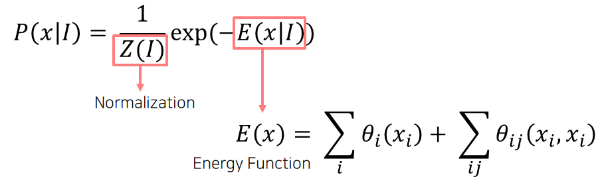

pairwise potential

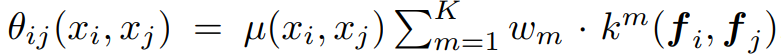

- 비슷한 위치의 픽셀은 같은 카테고리로 속하도록 함 (이미지 내 각 픽셀의 위치 차이)
- 비슷한 색상의 픽셀은 같은 카테고리로 속하도록 함(이미지 내 각 픽셀의 색상 차이)
- 특정 카테고리에 속하는 픽셀 개수를 일정 수준 이상이 되도록 함

In [ ]:
# losses

def resize_labels(labels, size):
    """
    Downsample labels for 0.5x and 0.75x logits by nearest interpolation.
    Other nearest methods result in misaligned labels.
    -> F.interpolate(labels, shape, mode='nearest')
    -> cv2.resize(labels, shape, interpolation=cv2.INTER_NEAREST)
    """
    new_labels = []
    for label in labels:
        label = label.float().numpy()
        label = Image.fromarray(label).resize(size, resample=Image.NEAREST)
        new_labels.append(np.asarray(label))
    new_labels = torch.LongTensor(new_labels)
    return new_labels

def build_metrics(model, batch, device):
    CEL = nn.CrossEntropyLoss(ignore_index=255).to(device)

    image_ids, images, labels = batch
    labels = resize_labels(labels, size=(41, 41)).to(device)
    logits = model(images.to(device))

    loss_seg = CEL(logits, labels)

    preds = torch.argmax(logits, dim=1)
    accuracy = float(torch.eq(preds, labels).sum().cpu()) / (len(image_ids) * logits.shape[2] * logits.shape[3])

    return loss_seg, accuracy